In [1]:
import pytorch_lightning as pl
from diffusers import AutoencoderKL, DDIMScheduler, UNet2DConditionModel
import torch
import os
from PIL import Image
from transformers import CLIPTextModel, CLIPTokenizer
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingLR
from models.pano.MVGenModel import MultiViewBaseModel
from einops import rearrange



/openbayes/input/input0/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/input0


/input0/ControlNet/controledMVSDiffusion/models/utils.py:541: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  homographys = torch.tensor(homographys)


/input0/ControlNet/controledMVSDiffusion/models/utils.py:553: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample["mask"] = torch.tensor(mask).float()


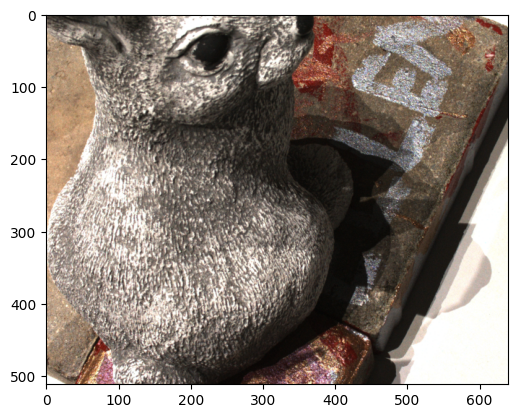

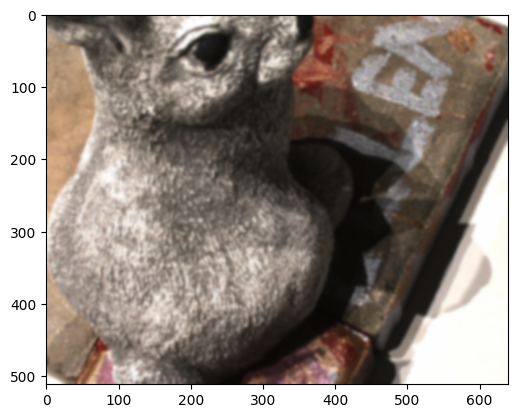

In [2]:
from models.utils import DTU,visualize_depth
import matplotlib.pyplot as plt
dataset = DTU(root_dir = "/openbayes/input/input0/dtu",split = "train",len = 2000)
plt.imshow(dataset.unpreprocess(dataset[0]["imgs"][0]).permute(1,2,0).detach().numpy())
plt.show()
plt.imshow(dataset.unpreprocess(dataset[0]["dark_imgs"][0]).permute(1,2,0).detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


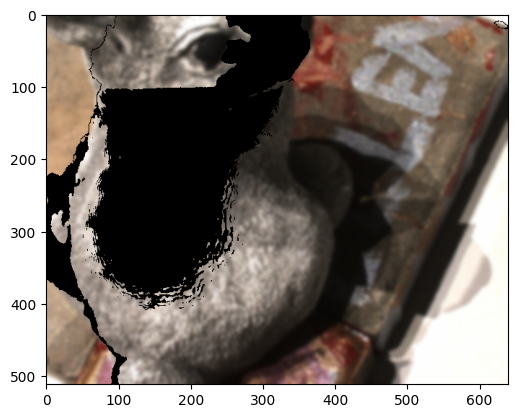

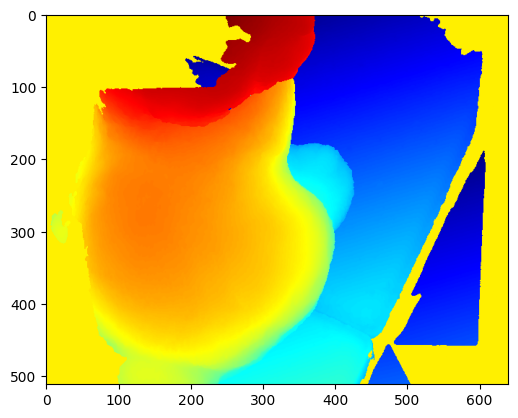

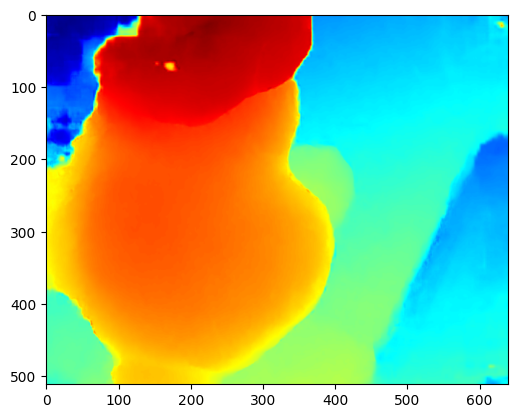

In [3]:
plt.imshow(dataset.unpreprocess(dataset[0]["dark_imgs"][0]).permute(1,2,0)*(dataset[0]["mask"].unsqueeze(2)).detach().numpy())
plt.show()
plt.imshow(visualize_depth(dataset[0]["depths"]).permute(1,2,0))
plt.show()
plt.imshow(visualize_depth(dataset[0]["pred_depth"]["depth_0"].squeeze(0)).permute(1,2,0))

In [4]:
from pano_outpaint import PanoOutpaintGenerator
import yaml
config = yaml.load(open("/openbayes/input/input0/ControlNet/controledMVSDiffusion/test.yaml","r"),Loader = yaml.FullLoader)

In [5]:

config = yaml.load(open("/openbayes/input/input0/ControlNet/controledMVSDiffusion/test.yaml", 'rb'), Loader=yaml.SafeLoader)
model = PanoOutpaintGenerator(config = config)
model.load_state_dict(torch.load("/openbayes/input/input0/weights/pano_outpaint.ckpt",
                                 map_location='cpu')['state_dict'], strict=False)
model = model.to("cuda")

In [6]:
from torch.utils.data import DataLoader
data_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=False)

In [7]:
from torch.utils.tensorboard import SummaryWriter
import glob
# Now you can use SummaryWriter
folders = glob.glob("/openbayes/home/tf_dir/controlnet_*")
folder = len(folders)+1
summary_path = "/openbayes/home/tf_dir/controlnet_{}".format(folder)    
writer = SummaryWriter("summary_path")


from torch.utils.data import DataLoader
data_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=False)

In [8]:
# load last model
model.load_state_dict(torch.load("/openbayes/input/input0/weights/pano_outpaint.ckpt",map_location='cpu')['state_dict']
                      , strict=False)
model.cuda()

PanoOutpaintGenerator(
  (text_encoder): CLIPTextModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 1024)
        (position_embedding): Embedding(77, 1024)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-22): 23 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): GELUActivation()
              (fc1): Linear(in_features=1024, out_features=4096, bias=True)
              (fc2): Linear(in_features=4096, out_

In [9]:
torch.save(model.state_dict(),"/openbayes/input/input0/ControlNet/controledMVSDiffusion/checkpoints/checkpoints.ckpt")

In [10]:

optimizer = model.configure_optimizers()["optimizer"]


/openbayes/input/input0/venv/lib/python3.8/site-packages/torch/optim/adamw.py:50: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super().__init__(params, defaults)


In [11]:
epochs = 200
model.train()
count = 0
loss_min = 1000000000
for epoch in range(epochs):
    data_loader = iter(data_loader)
    data_loader_iter = iter(data_loader)
    while True:
        try:
            data = next(data_loader_iter)
        except StopIteration:
            break
        count+=1
        for key in data:
            try:
                data[key] = data[key].cuda()
            except:
                pass
        optimizer.zero_grad()
        loss = model.training_step(data,0)
        loss.backward()
        optimizer.step()
        if count%200 == 0:
            print(loss)
            writer.add_scalar("loss",loss,count)
            if loss < loss_min:
                loss_min = loss
                torch.save(model.state_dict(),
                "/openbayes/input/input0/ControlNet/controledMVSDiffusion/checkpoints/checkpoints.ckpt")
            with torch.no_grad():
                model.eval()
                data = next(data_loader_iter)
                for key in data:
                    try:
                        data[key] = data[key].cuda()
                    except:
                        pass
                image_pred = model.validation_step(data,0)
                writer.add_scalar("val_loss",loss,count)
                writer.add_image("image_mask",image_pred[0][0],count)
                
        
        

/input0/ControlNet/controledMVSDiffusion/models/utils.py:553: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample["mask"] = torch.tensor(mask).float()
/openbayes/input/input0/venv/lib/python3.8/site-packages/diffusers/configuration_utils.py:134: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/openbayes/input/input0/venv/lib/python3.8/site-packages/pytorch_lightning/core/lightning.py:417: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't be

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 23.65 GiB total capacity; 23.11 GiB already allocated; 21.19 MiB free; 23.14 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
data["homographys"].shape


torch.Size([1, 3, 3, 3, 3])

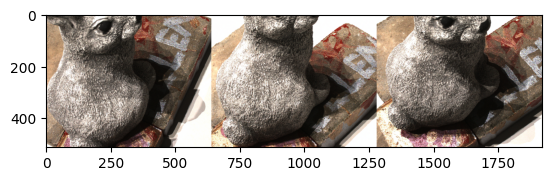

In [ ]:
from einops import rearrange
image_real = [image for image in image_pred[2][0]]
image = torch.cat(image_real,dim = 2)
image.shape
plt.imshow(dataset.unpreprocess(image).permute(1,2,0).detach().cpu().numpy())

In [ ]:
image_pred[1].shape,image_pred[0].shape,image_pred[2].shape

((1, 3, 512, 640, 3),
 torch.Size([1, 3, 3, 512, 640]),
 torch.Size([1, 3, 3, 512, 640]))

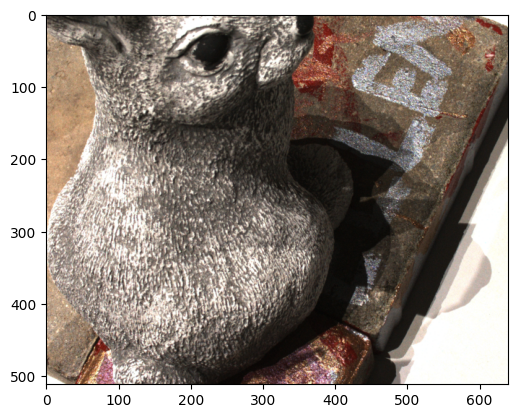

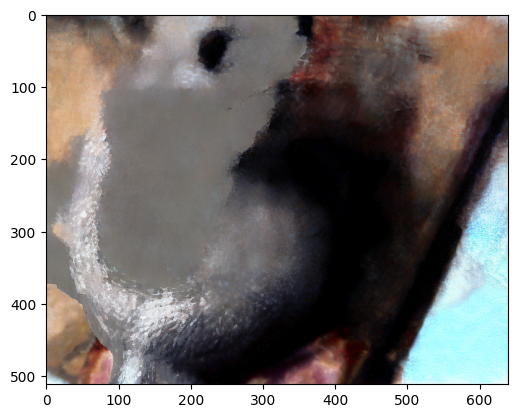

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

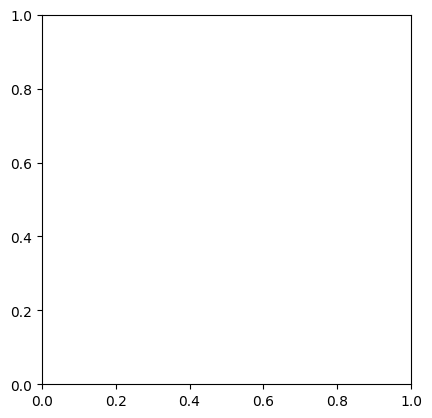

In [ ]:
plt.imshow(dataset.unpreprocess(image_pred[2][0][0].cpu()).permute(1,2,0))
plt.show()
plt.imshow(image_pred[1][0][0])
plt.show()
plt.imshow(image_pred[2][0][0])
plt.show()